In [ ]:
# Setup the dependency for running on gogole colab <https://colab.research.google.com/>
#
if 'google.colab' in str(get_ipython()):
    !pip install lightkurve xmltodict memoization
    # ensure we get the latest copy of the dependent scripts
    !rm -fr PH_TESS_I_LightCurveViewer
    !git clone https://github.com/orionlee/PH_TESS_I_LightCurveViewer.git
    
    # add the notebook directory so path so that the python files there can be imported
    import sys
    sys.path.append('./PH_TESS_I_LightCurveViewer')
    print('Dependency setup for google colab completed.')

In [1]:
import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
import tic_plot as tplt
from tic_plot import TransitTimeSpec, TransitTimeSpecList

import asyncio_compat

import math
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.time import Time
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

%matplotlib inline


In [3]:
# a menu to jump to speicific section easily
display(HTML("""
<script>
function addSideNav() {
    let ctr = document.getElementById('nav-ctr');
    if (ctr) { ctr.remove(); }
    const sections = [
        ['#input-tic', 'Enter TIC...'],
        ['#tic-metadata', ['TIC Metadata']],
        ['#lc-all', 'Lightcurves - all'],
        ['#lc-interactive', 'Interactive'],
        ['#lc-zoomed-in', 'Zoomed-in'],
        ['#centroid-offsets', 'Centroid Offsets'],
        ['#lc-transits', 'Transit Times'],
        ['#lc-background-sso', 'Bkg / SSO'],
        ['#lc-fold', 'Folding'],
        ['#lc-period', 'Period / BLS'],
        ['#tpf_download', 'TPF Download'],
        ['#tpf_zoom_in', 'TPF Zoom in'],
    ];
    // avoid and arrow functions and string with backslash n 
    // they cause parsing failure with jupyter's display(HTML())
    function toASection(sec) {
      return `              <li><a href="${sec[0]}">${sec[1]}</a></li>`;
    }
    const sectionsHTML = 
        sections.map(toASection).join(`
`);
    document.body.insertAdjacentHTML('beforeend', `
<div id="nav-ctr">
    <style>
        #nav-side {
            position: fixed; right: 2.5vh; top: 2.5em; z-index: 999;
            background-color: #feefc3; border: 1px solid lightgray; border-radius: 10%;
            padding: 0.25em 2ch 0.25em 0.5ch;        
        }
        #nav-side.expand {
            padding: 0.25em 2ch;                
        }
        #nav-side-expand {
            display: none;
        }
        .expand #nav-side-expand {
            display: block;
        }
        #nav-side-ctl-hideshow:before {
            content: "<<";
        }
        .expand #nav-side-ctl-hideshow:before {
            content: ">>";
        }
    </style>
    <div id="nav-side" class="expand"
         style="">
        <div id="nav-side-ctl-hideshow" style="float: right; cursor: pointer;" onclick="this.parentElement.classList.toggle('expand');"></div>
        <div id="nav-side-expand">
            EB Vetting
            <ul>
${sectionsHTML}
            </ul>
        <div id="nav-side-expand">
    </div>
</div>

`);
}
addSideNav();
"""));


## Enter TIC, sector, subject
<a name="input-tic">

In [2]:
# Run All Above and this cell to start
#
# TIC   : Subject metadata
# sector: the sector that the notebook would use by default as the focus,
#         the lightcurves from all other sectors would be downloaded as well.
# subject: Subject number on Planet Hunters TESS for the TIC-sector lightcurve

tic, sector, subject = 248990782, 5, 30974885

max_num_sectors_to_download = 3  #  None to download all sectors. Otherwise set it to a number to cap it, with the supplied sector as the centor of the slice to donwload
to_download_tpf_async = True
to_show_tic_meta = True


def limit_sr_to_download(sr):
    # use primary mission data only for this vetting
    sr = lk.SearchResult(sr.table[sr.table["sequence_number"] <= 26])
    if max_num_sectors_to_download is None:
            return sr
    return lke.of_sector_n_around(sr, sector, num_additions=max_num_sectors_to_download-1)

if hasattr(lk.search, "sr_cache"):
    lk.search.sr_cache.cache_dir = 'data'
    lk.search.sr_cache.expire_seconds = 86400 * 7

try:    
    lcf_coll, sr, sr_unfiltered = lke.download_lightcurves_of_tic_with_priority(tic, download_filter_func=limit_sr_to_download, download_dir="./data")
finally:
    tplt.beep()  # a beep to remind the users that the data has been downloaded


# Start downloading TPF asycnhronously while the user inspects the lightcurve
# Users can jump to "TPF Download" section to access the result
tpf_task = None
if to_download_tpf_async:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir="data")


metadata_html_task = None  # load TCEs asycnhronously  while the user inspects the lightcurve
if to_show_tic_meta:
    metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir="data")

3 rows filtered


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,248990782,0.0
1,TESS Sector 32,2020,SPOC,120,248990782,0.0


TIC 248990782 	#sectors: 1 ; 5 - 5
   sector 5: 	camera = 1 ; ccd = 2


In [ ]:
# when needed, run this cell to download all sectors from primary mission, 
lcf_coll = lk.SearchResult(sr.table[sr.table["sequence_number"] <= 26]).download_all(download_dir="data")
lcf_coll

## TIC Metadata
<a name="tic-metadata">

In [3]:
# reload(tplt)
# metadata_html_task = asyncio_compat.create_background_task(tplt.get_tic_meta_in_html, of_sector(lcf_coll, sector), a_subject_id=subject, download_dir="data")
display(HTML(await metadata_html_task))

RS (in R☉),1.850
Magnitude (TESS),9.04
T_eff (in K),7869.0


## Lightcurves - all sectors
<a name="lc-all">

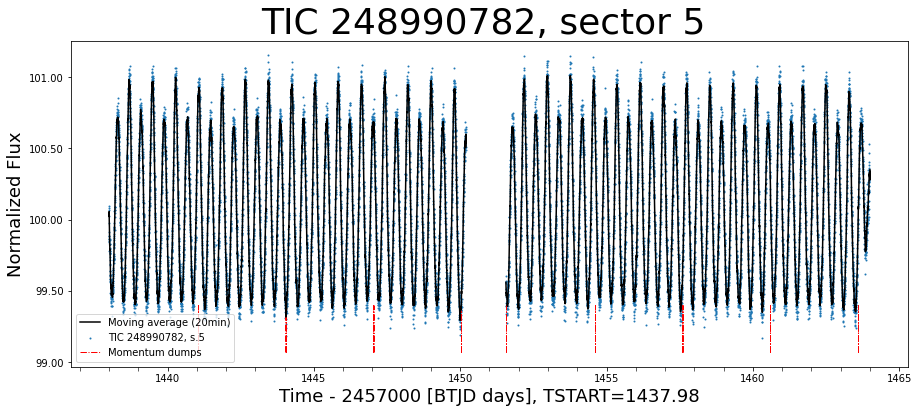

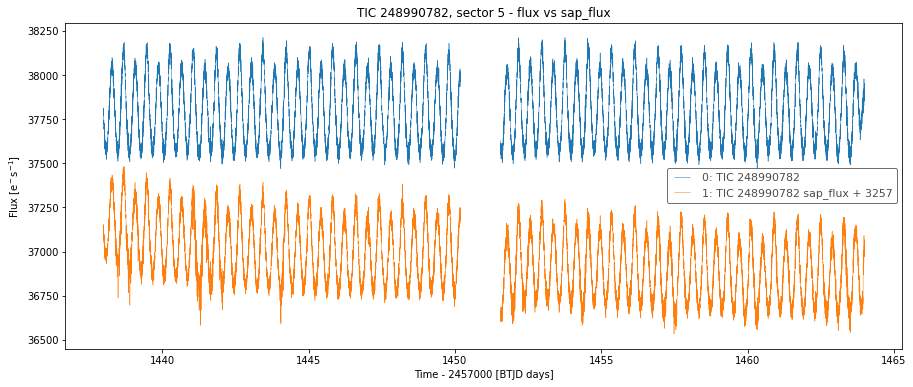

In [4]:
%matplotlib inline

tplt.print_data_range(lcf_coll)

figsize=(15,6)
axs = tplt.plot_all(
#                     of_sectors(lcf_coll, 1)   
                    lke.of_sector_n_around(lcf_coll, sector, num_additions=8)
#                     , flux_col = 'sap_flux'  
                    , moving_avg_window='20min' # None # '30min'
#                     , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=7) 
#                     , lc_tweak_fn=lambda lc: lc[:3000]
              , ax_fn=lambda: plt.figure(figsize=figsize).gca()
#                   , use_relative_time=True
                    , mark_quality_issues=False
#                     , mark_momentum_dumps=False
#               , set_title=False
              , ax_tweak_fn=lambda ax: [
#                                             ax.set_ylim(97, 101.5),
                                       ]
             )

# as a sanity check, in case PDCSAP_FLUX has some anomaly (e.g., remvoing a good dip)
ax_flux_cmp = tplt.plot_flux_sap_flux_comparison(of_sector(lcf_coll, sector), ax=plt.figure(figsize=figsize).gca(),
                                                 offset=None)

# axs[-1].set_ylim(96, 104);
# axs[0].set_xlim(1604.4, 1605.4)
# axs[0].vlines(1604.9, 95.0, 98.0, color='r', linestyle='--', label="flare")
# axs[0].legend()

In [ ]:
# Help to understand the quality issues marked by dotted red line in plot_all()
for lcf in of_sectors(lcf_coll, sector):
    qual_time, qual_flags = lke.list_times_w_quality_issues(lcf)  # check PDCSAP_FLUX
    print(f"Sector {lcf.meta['SECTOR']}: ", [(tplt.as_4decimal(t), lk.utils.TessQualityFlags.decode(f)) for t, f in zip(qual_time, qual_flags)])

## Lightcurve - interactive
<a name="lc-interactive">

In [5]:
%matplotlib inline

# interactively view a lightcurve 
lcf = of_sector(lcf_coll, sector)

sector = lcf.sector # override the sector in case I want to check some other ones


#  From section 4.1.2 of the paper TOI catalog from TESS primary mission
#  https://arxiv.org/pdf/2103.12538.pdf
# less reliable when it is < 0.8
if lcf.meta.get("CROWDSAP") is not None:
    display(HTML(f"""Fraction of flux in aperture attributed to the target: 
    <span style="background-color: {'red' if lcf.meta.get("CROWDSAP") < 0.8 else 'transparent'}; padding: 2px;">{lcf.meta.get("CROWDSAP")}</span>"""));

display(HTML(f"TSTART: {lcf.meta.get('TSTART')}"))  # To aid relative time conversion


# make zoom in to a specific dip eaiser
tplt.plot_transit_interactive(lcf, figsize=(30, 10)
#                               ,flux_col='sap_flux'
                             );

Output(layout=Layout(border='1px solid lightgray', padding='1em 0px'))

Output(layout=Layout(padding='1em'))

## Lightcurve - zoomed in
<a name="lc-zoomed-in">

Transits, zoomed-in


label,epoch,duration_hr,period
str9,float64,float64,float64
primary,1439.67,4.0,0.794
secondary,1440.07,4.0,0.794


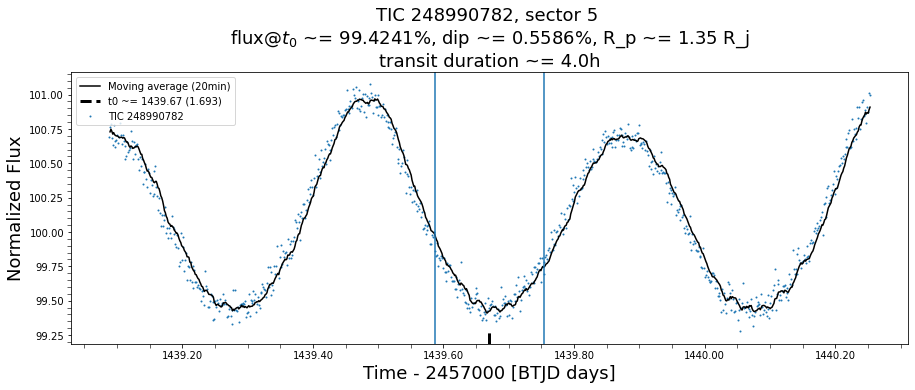

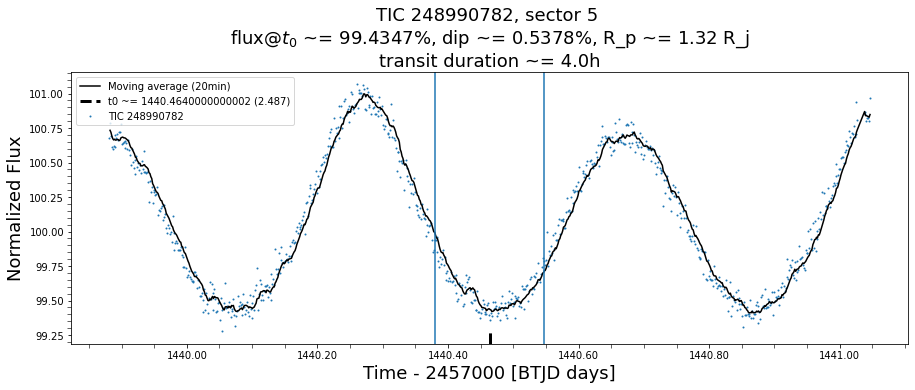

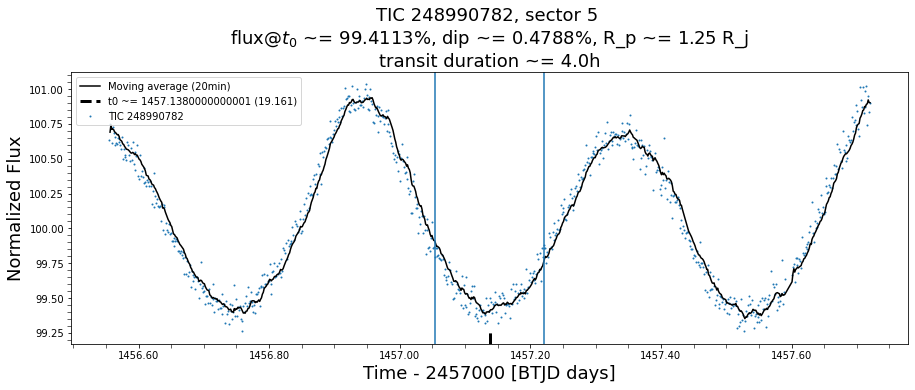

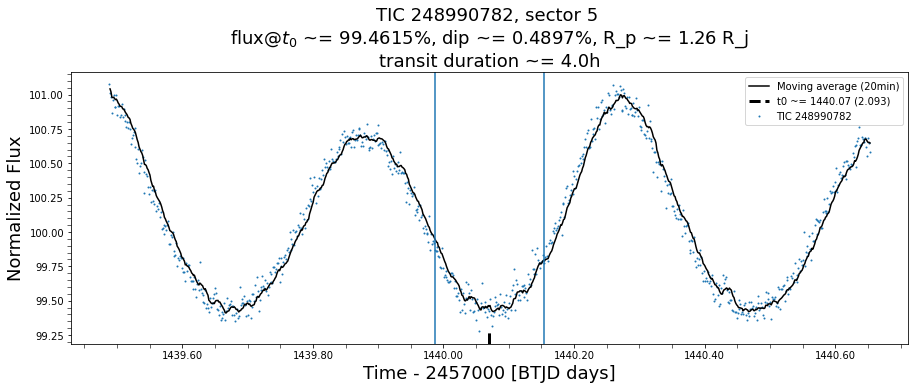

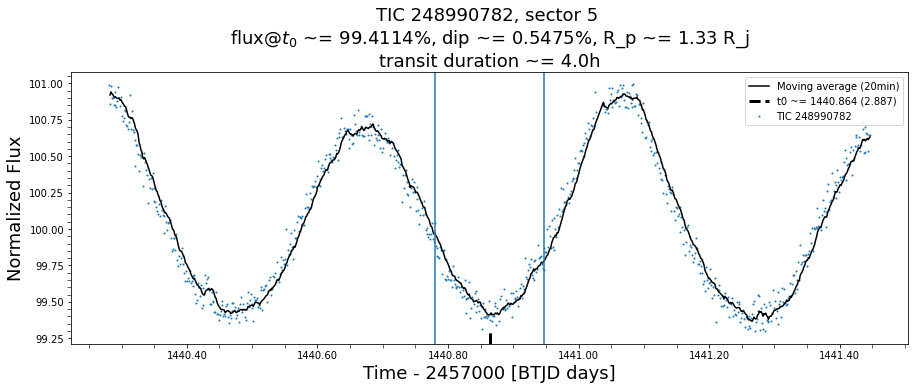

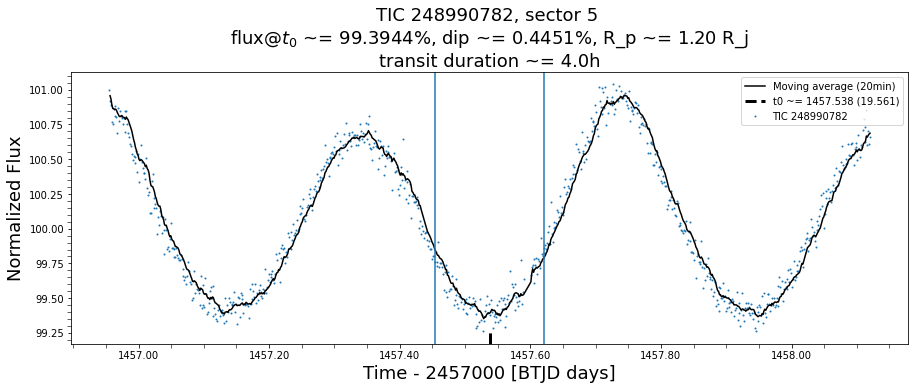

In [7]:
# Plots, zoomed-in around selected dips / transits
%matplotlib inline

# (Also useful in many subsequent cells as the default zoom-in point)
# transit_specs for calling plot_transits()
transit_specs = TransitTimeSpecList(
    dict(epoch=1439.67, duration_hr=4.0, label="primary",
         sector=5, steps_to_show=[0, 1, 22],
        ),
    dict(epoch=1440.07, duration_hr=4.0, label="secondary",
         sector=5, steps_to_show=[0, 1, 22],
        ),
    defaults=dict(period=0.794, surround_time=1.0)
    )

def custom_lc_tweak(lc):
    res = lc
    res = res.remove_outliers(sigma=7)
    res = res.bin(time_bin_size=20 * u.min)
    res.meta.update(lc.meta)  #compensate LCv2 bug in bin
    return res

figsize = (15, 5) # (12,6)  # (15, 9)  
axs = tplt.plot_transits(    
                         lcf_coll # [of_sectors(lcf_coll, 27)[1], of_sectors(lcf_coll, 28)[1]]
                         , transit_specs
#                          , flux_col = "sap_flux"
                         , ax_fn=lambda: plt.figure(figsize=figsize).gca()    
                         , t0mark_ymax=0.05
#                          , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=7)
#                          , lc_tweak_fn=custom_lc_tweak
                         , moving_avg_window='20min' # None # '30min' # '10min' # None, '20min' #  '30min'
#                          , set_title=False
                        , ax_tweak_fn=lambda ax: [
#                        , ax.axvline(2002.8274702863073, c='r', linestyle='--')
                        ]
                        )
# axs[0].set_ylim(None, 100.15)
print('Transits, zoomed-in');
display(transit_specs.to_table());

## Centroid offsets
<a name="centroid-offsets">

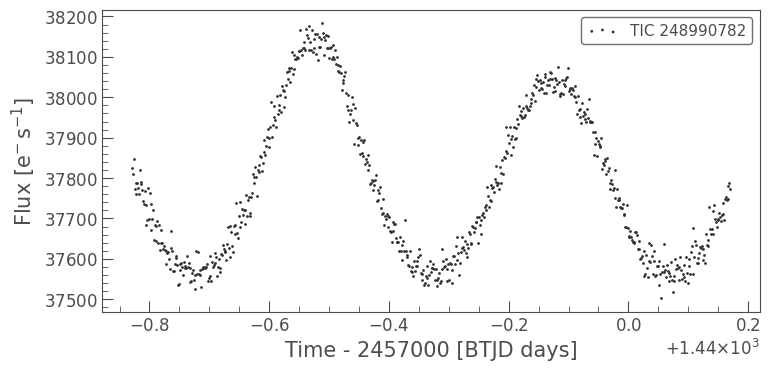

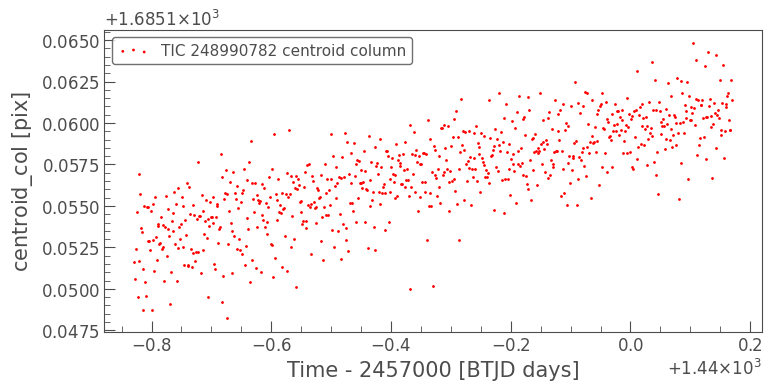

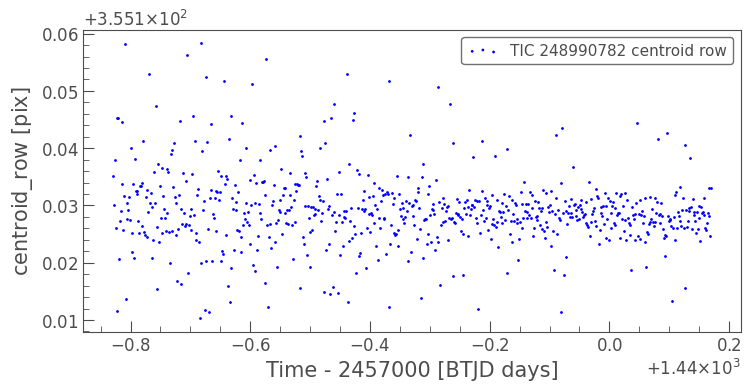

In [8]:
specs_idx, step_idx = 0, 0
surround_time = 1.0

t0 = transit_specs[specs_idx]["epoch"]
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]

lc_trunc = of_sector(lcf_coll, transit_specs[specs_idx]["sector"]).truncate(t0 - surround_time /2, t0 + surround_time /2)
lc_trunc.scatter();
lc_trunc.scatter(column="centroid_col", c="red", label=f"{lc_trunc.label} centroid column");  # mom_centr1
lc_trunc.scatter(column="centroid_row", c="blue", label=f"{lc_trunc.label} centroid row");  # mom_centr2


In [ ]:
# highlight the middle of the dip (middle 70%) to see if the distribution of the centroid is different
highlight_time_range = (transit_specs[0]["epoch"] - transit_specs[0]["duration_hr"] / 24 * 0.35, transit_specs[0]["epoch"] + transit_specs[0]["duration_hr"] / 24 * 0.35)
tplt.scatter_centroids(lc_trunc, highlight_time_range=highlight_time_range);
# tplt.animate_centroids(lc_trunc, num_obs_per_frame=15, accumulative=False);
"Centroid movement";

# Transit Times
<a name="lc-transits">

In [ ]:
# plot transit times for a list of sectors, not just one
%matplotlib inline

red_marks = dict(linestyle='--', color="red")
blue_marks = dict(linestyle='--', color="blue")

# customize these parameters if needed
lcf_coll_to_use = lcf_coll
# lcf_coll_to_use = of_sectors(lcf_coll, 30, 31, 32, 33, 34, 35, 36)
# lcf_coll_to_use = lcf_coll[(lcf_coll.sector >= 1) & (lcf_coll.sector <= 13)]
tt_specs = transit_specs
axvline_kwargs_specs = [
    red_marks,
    blue_marks
]
skip_no_transit_plot = True

# Now do the marking
axs, tt_lists = [], []
for lc_to_use in lcf_coll_to_use :
    with warnings.catch_warnings():
        # avoid warnings about repeated normalization
        warnings.filterwarnings("ignore", category=lk.LightkurveWarning, message=".*in relative units.*")
#         lc_to_use = tplt._to_lc_with_flux(lc_to_use, "sap_flux")
        lc_to_use = lc_to_use.normalize(unit="percent")  # .remove_outliers(sigma=7)
    ax = plt.figure(figsize=(25, 5)).gca()
    ax1, tt_list = tplt.mark_transit_times(lc_to_use, tt_specs,
                                           axvline_kwargs_specs=axvline_kwargs_specs,
                                           ax=ax,
                                           skip_no_transit_plot=skip_no_transit_plot,
#                                            lc_plot_func_name="plot",
                                          )
    if ax1 is not None:
        axs.append(ax1), tt_lists.append(tt_list)
    else:
        plt.close(ax.figure)

print(tt_specs);
print(tt_lists);
# axs[-1].set_ylim(None, 100.5)

# Fold
<a name="lc-fold">

In [ ]:
# Fold lightcurves

# optionally use only specific sectors
# lc = of_sectors(lcf_coll, 8,9,10,11,12,13,27).stitch(corrector_func=tplt.normalize_percent)
# lc = lcf_coll[lcf_coll.sector == sector].stitch(corrector_func=tplt.normalize_percent)
# lc = of_sectors(lcf_coll, *sr[[sr.author == "SPOC"]].table["sequence_number"]).stitch(corrector_func=tplt.normalize_percent)
lc = lke.of_sector_n_around(lcf_coll, sector, num_additions=8).stitch(corrector_func=tplt.normalize_percent)
# lc = lcf_coll[(lcf_coll.sector >= 27) & (lcf_coll.sector < 36)].stitch(corrector_func=tplt.normalize_percent)

t0 = transit_specs[0]["epoch"]
period = transit_specs[0]["period"]

figsize = (12, 6)
time_bin_size = 20 * u.minute

# pre-rocess the specified the LC before folding

lc = lc.remove_outliers(sigma=7)
# lc["flux_mavg"] = tplt.add_flux_moving_average(lc, "60min")["flux_mavg"]

lc_b = lc.bin(time_bin_size = time_bin_size)
lc_b.meta.update(lc.meta)


# ax1, lc_f1 = tplt.fold_and_plot_odd_even(lc_b, period, t0,
#                                          figsize=figsize, title_extra=f", binned with {time_bin_size}");
# ax1.set_ylim(0.975, 1.01);
# ax1.set_xlim(-0.1, 0.1);

ax2, lc_f2 = tplt.fold_2x_periods_and_plot(lc_b, period, t0,
                                           figsize=figsize, title_extra=f", binned with {time_bin_size}");
# ax2.set_title(ax2.get_title() + "\n more info")
# ax2.plot(lc_f2.time.value, lc_f2.flux_mavg, label="moving average 1 hour", c="black", linewidth=1);  # add moving average
# ax2.legend();

In [ ]:
# Detrend then fold

window_length_days = 12 / 24
lc_flattened = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days))

# lc.scatter()
ax = lc_flattened.scatter()  # ax=ax, c='b'
ax.set_title(f'{lc.label}, flattened with a window {window_length_days} days')

fold_and_plot(lc_flattened, ', flattened');

fold_2periods_and_plot(lc_flattened, ', flattened');


### Mask out eclipses
to visualize the remaining fluctuations

In [ ]:
t_mask = lc_b.create_transit_mask(transit_time=transit_specs.epoch, period=transit_specs.period, duration=transit_specs.duration)
lc_masked = lc_b[~t_mask]

with plt.style.context(lk.MPLSTYLE):
    ax1 = plt.figure(figsize=(25, 5)).gca()    
    ax1 = lc_masked.scatter(ax=ax1);
#     lc_masked.fold(epoch_time=2026, period=3.2263899).scatter();

# Period / BLS
<a name="lc-period">

In [ ]:
# run BLS against all / subset of data 

# lc = of_sectors(lcf_coll).PDCSAP_FLUX.stitch()
# lc = lcf_coll[0].PDCSAP_FLUX
lc = of_sector(lcf_coll, sector)
lc = lc.normalize()

print('Num of observations:', len(lc))
print('Observation elapsed time:', lc.time.max()  - lc.time.min())

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lc.interact_bls()

# if False: 
if False: 
    x_min = 1
    x_max = 20
    # Box Least Square assumes U-shaped transit model (rapid dips)
    pdg_bls = lc.remove_nans().to_periodogram(method='bls')
    print('BLS')
    pdg_bls.show_properties()
    ax = pdg_bls.plot()
    ax.set_title('BLS Periodogram, in period')
    ax.set_xlim(x_min, x_max)

    # Lomb Scargle better for general vairable curves with sin-like shape (gradual flucutation)
    pdg_ls = lc.remove_nans().to_periodogram(method='lombscargle')
    print('Lomb Scargle')
    pdg_ls.show_properties()
    ax = pdg_ls.plot(view='period')
    ax.set_title('Lomb Scargle Periodogram, in period')    
    ax.set_xlim(x_min, x_max)
    
    

# Lightcurve - background / SSO
<a name="lc-background-sso">

    

t0= 1439.67


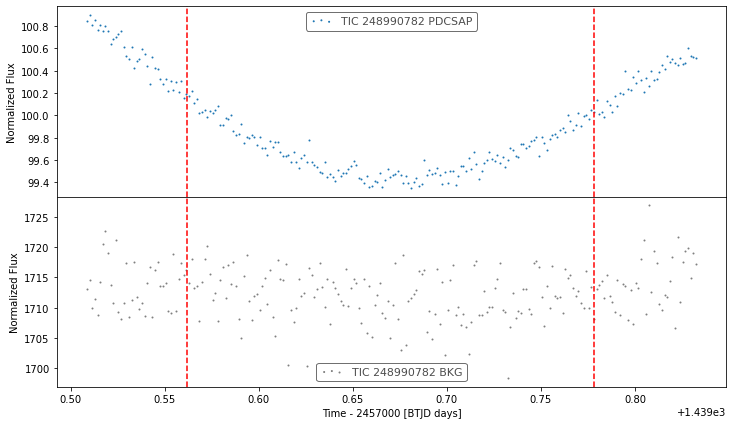

In [9]:
# reload(lke)

specs_idx, step_idx = 0, 0

# lcf = lcf_coll[-1]
lc = of_sector(lcf_coll,  transit_specs[specs_idx]["sector"])
lc = lc.normalize(unit='percent')

# Check the background flux for the duration in question
t0 = transit_specs[specs_idx]["epoch"]
period = transit_specs[specs_idx]["period"]
search_period = transit_specs[specs_idx]["duration_hr"] * 1.3 / 24
plot_period = search_period * 1.5 

steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]

search_start, search_end = t0 - search_period /2, t0 + search_period /2
plot_start, plot_end = t0 - plot_period /2, t0 + plot_period /2

plot_binned = False
plot_sap_flux = False

fig, axs = plt.subplots(3 if plot_binned else 2, 1, sharex=True, figsize=(12, 10.5 if plot_binned else 7))
fig.subplots_adjust(hspace=0)

time_mask = (lc.time.value >= plot_start) & (lc.time.value <= plot_end)
if plot_binned:
    lc_b = lc.bin(time_bin_size = 20 * u.minute)  # bin it to speed up SSO search
    if len(lc_b.meta) < 1: # to compensate lkv2 bugs in .bin() ; needed for query SSO
        lc_b.meta.update(lc.meta)  
    lc_b[(lc_b.time.value >= plot_start) & (lc_b.time.value <= plot_end)].scatter(ax=axs[0], label=lc.label + ' binned')

if plot_sap_flux:
    lc_sap[time_mask].scatter(column='sap_flux', ax=axs[-2], c='orange', label=lc.label + 'SAP')
else:
    lc[time_mask].scatter(ax=axs[-2], label=lc.label + ' PDCSAP')
    
lc_bkg = lke.get_bkg_lightcurve(lc)
lc_bkg[time_mask].scatter(ax=axs[-1], color='gray')

if True and search_start is not None:
    for ax in axs:
        ax.axvline(search_start, linestyle='--', c='r')
        ax.axvline(search_end, linestyle='--', c='r')

print('t0=', t0);

In [ ]:
lc_to_search = lc_b # use the binned one to speed up search
radius_in_arcsec = 168 # 315 # 168 ~= 8 pixels, should cover the range of entire Target Pixel file (11x11 pixels, with the target at center)
cadence_mask = (lc_to_search .time.value >= search_start) & (lc_to_search .time.value <= search_end)
# t_epoch = 2016.1330800000578
# duration_hr = 21.3918
# surround_time = 1
# duration = duration_hr / 24
# t0 = t_epoch
# df_sso = lc_to_search.query_solar_system_objects(cadence_mask=(lc.time >= t0 - (duration + surround_time)/2) & (lc.time <= t0 + (duration + surround_time)/2))

try:
    df_sso = lc_to_search.query_solar_system_objects(cadence_mask=cadence_mask, radius=radius_in_arcsec/60/60)
    df_sso['epoch_btjd'] = df_sso['epoch'] - 2457000
    df_sso['epoch_relative'] = df_sso['epoch_btjd'] - lc_to_search.meta.get('TSTART')
    display(df_sso)
finally: 
    tplt.beep();


# TPF Download
<a name="tpf_download">

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,248990782,0.0


TessTargetPixelFile(TICID: 248990782)  , sector 5
     time: 1437.9823180412504 - 1464.2924369280338
cadenceno: 151576 - 170519


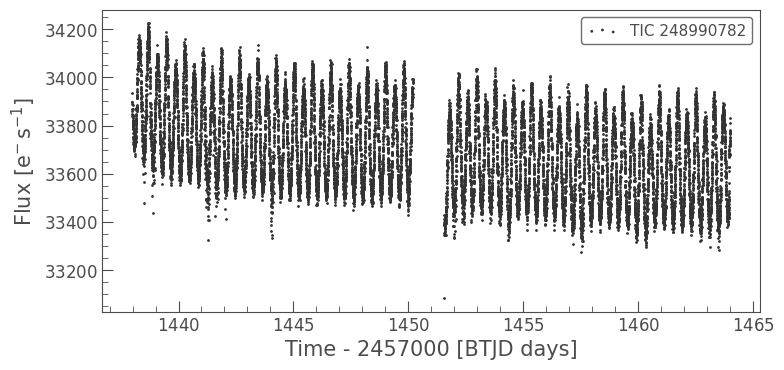

In [10]:
# Google colab user: this cell will fail with SyntaxError in await
# use the next cell instead.

global tpf_task  # need to define it as global, otherwise UnboundLocalError would occur
if tpf_task is None:
    tpf_task = lke.create_download_tpf_task(f"TIC{tic}", sector=sector, exptime="short", author='SPOC', mission="TESS", download_dir="data")
# else the download has been previoulsy initiated (in "Enter TIC" section, no need to do it),
#      no need to do it again

try:
    tpf_coll, sr_tpf = await tpf_task
    display(sr_tpf)
    
    if tpf_coll is not None and len(tpf_coll) > 0: 
        tpf =  tpf_coll[0]

        print(tpf, " , sector", tpf.sector)
        print("     time:", tpf.time.min() , "-", tpf.time.max())
        print("cadenceno:", tpf.cadenceno.min() , "-", tpf.cadenceno.max())

        lc = tpf.to_lightcurve().remove_outliers(sigma=7)
        ax = lc.scatter();
#         ax.set_ylim(3800, None)
finally: 
    tplt.beep()
    tpf_task = None  # once task result is conusmed, reset it so that one can run it again in the next run

In [ ]:
# For use in google colab, where await syntax is not supported (in the older IPython)
if tpf_task.done():
    tpf_coll, sr_tpf = tpf_task.result()
    display(sr_tpf)
    tpf =  tpf_coll[0]

    print(tpf, " , sector", tpf.sector)
    lc = tpf.to_lightcurve().remove_outliers(sigma=7)
    ax = lc.scatter();
else:
    print("Background downloading TPF is not complete yet. Try again later.")


# TPF Zoom in
<a name="tpf_zoom_in">

In [11]:
ylim_func = lambda lc: (np.nanmin(lc.flux), np.nanmax(lc.flux))
# ylim_func = lambda lc: (np.nanpercentile(lc.flux, 0.1), np.nanpercentile(lc.flux, 99.9))

specs_idx, step_idx = 0, 0
t0 = transit_specs[specs_idx]["epoch"]
duration = transit_specs[specs_idx]["duration_hr"] / 24
period = transit_specs[specs_idx]["period"]
steps_to_show = transit_specs[specs_idx]["steps_to_show"]
t0 = t0 + period *  steps_to_show[step_idx]
surround_time = 0.50

plot_start, plot_end = t0 - duration / 2 - surround_time / 2,  t0 + duration /2 + surround_time / 2


print('t0 =', t0);

# zommed in to the time around the dip 
tpf_trunc = tpf[(tpf.time.value >= plot_start) & (tpf.time.value <= plot_end)]  # for Lightkurve 2 API

# zoom to arbitrary date range
# tpf_trunc = tpf[(tpf.time >= tpf.time.min() + 3) & (tpf.time <= tpf.time.min() + 12)]

if len(tpf_trunc) < 1:
    display(HTML("""<font style="background-color: red;">WARNGING:</font> the truncated TPF is zero length. Sunsequent operations would fail."""))


if (tpf_trunc.time.max() - tpf_trunc.time.min()) > 3 * u.day:
    display(HTML(('<span style="background-color: yellow">Note:</span> The TPF spans over a long time. Consider to zoom in. Duration: '
                  f'{(tpf_trunc.time.max() -tpf_trunc.time.min()).to(u.day)}')))

if 'google.colab' in str(get_ipython()):
    tpf_trunc.to_lightcurve().scatter();
else: 
    tpf_trunc.interact(ylim_func=ylim_func
#                        , aperture_mask=tpf.background_mask
                       , transform_func=tplt.normalize_percent
                      );

t0 = 1439.67


In [12]:
tpf_mag = tpf_trunc.meta.get("TESSMAG")
print('Target magnitude: ', tpf_mag)
magnitude_limit = tpf_mag + 8 if tpf_mag is not None else 18

tplt.show_tpf_orientation(tpf)
tplt.interact_sky(tpf_trunc, aperture_mask="pipeline", magnitude_limit = magnitude_limit);
tplt.show_nearby_tic_summary_form();

Target magnitude:  9.03899956


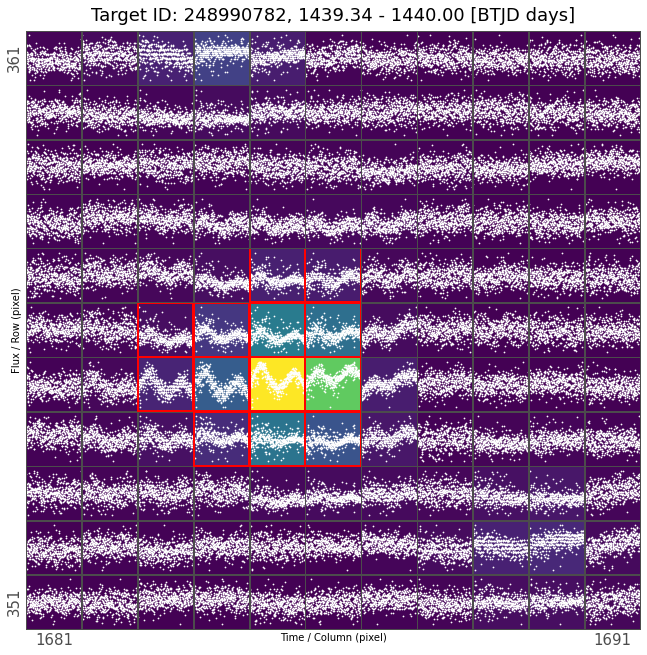

In [13]:
pixel_size_inches = 1.0
fig = plt.figure(figsize=(tpf.flux[0].shape[1] * pixel_size_inches, tpf.flux[0].shape[0] * pixel_size_inches))
ax = tpf_trunc.plot_pixels(ax=fig.gca(), aperture_mask=tpf_trunc.pipeline_mask, show_flux=True, markersize=1.5);
tplt.beep();

(Insert relevant portion from TCE vetting when applicable.)

In [ ]:
ax = tpf_trunc.plot(aperture_mask='pipeline', mask_color='red');
ax = tpf_trunc.plot(ax=ax, aperture_mask=tpf_trunc.background_mask, mask_color='lightgray');

In [ ]:
tpf_trunc.animate(aperture_mask='pipeline', mask_color='red')  # , scale="log", scale="sqrt" 